
# <center>PINNs with DeepXDE </center>

<a id="0"></a> <br>
 # Table of Contents
1. [Ordinary differential equations](#9)
    1. [The airy equation](#1)     
    1. [Lorenz' attractor](#2)
    1. [Kepler problem](#3)
1. [Ordinary differential equations](#10)
    1. [Wave equation](#4)
    1. [Poisson equation](#5)
    1. [Eikonal equation](#6)
    1. [Burgers' equation](#7)
    1. [Camassa-Holm equation](#8)

In [ ]:
!pip install deepxde &> /dev/null
# !pip install eikonalfm &> /dev/null

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf

import scipy
from scipy.special import gamma, airy
from scipy.integrate import solve_ivp, odeint
from scipy.optimize import minimize
import deepxde as dde

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


<a id="9"></a>
# Part 1: Ordinary differential equations

In this notebook, we will try to solve a set of ordinary differential equations (ODEs) given initial conditions. For this end, we will use SciPy, a numerical analysis module for Python, and DeepXDe, a machine learning framework for solving differential equations. We will then compare the solutions of the two approches.

For the instructions on how to install SciPy, please see https://scipy.org/install/, and for the installation of DeepXde see here https://deepxde.readthedocs.io/en/latest/user/installation.html.

A first-order ordinary differential equation is an equation of the form $$\frac{dx}{dt} = f(t,x),\qquad \tag{1}$$
with given $x(0)=x_0$, and where $x\colon I \to \mathbb{R}^n,\, f\colon \mathbb{R}^{n+1}\to \mathbb{R}^{n}$ for some interval $I\subset \mathbb{R}$, and $n\in \mathbb{N}$.

A higher-order ordinary differential equation can always be rewritten in the form (1).

<a id="1"></a>
## The Airy equation: PINNs success

For example, consider the following second-order differential equation, called **Airy equation**.
$$
\frac{d^2x(t)}{dt^2}-tx(t)=0 \qquad \tag{2}
$$
with initial conditions  $$ x(0) = \frac{1}{3^{2/3}\Gamma\left(\frac{1}{3}\right)} \qquad \text{and} \qquad x'(0)=-\frac{1}{3^{2/3}\Gamma\left(\frac{1}{3}\right)}\qquad \tag{3}.
$$

The Airy equation has two lineary independent solutions $Ai(t)$ and $Bi(t)$. The one one initial conditions (3), and which we will denote by $Ai(t)$, is known as the Airy function.

Let's first rewrite the Airy equation in the form of Equation (1) by setting $ y = \begin{pmatrix} x' \\ x\end{pmatrix}$. Equation (2) becomes
$$
\frac{dy}{dt} = \begin{pmatrix} \frac{d^2 x}{dt}\\ \frac{dx}{dt}\end{pmatrix} \overset{(2)}{=} \begin{pmatrix}tx \\ x'\end{pmatrix} = \begin{pmatrix}0 & t  \\ 1 & 0 \end{pmatrix} \begin{pmatrix}x' \\ x\end{pmatrix}.
$$
Thus Equation (2) is equivalent to $$ \frac{dy}{dt} = M(t)y\qquad \tag{4}$$ with $M(t) = \begin{pmatrix}0 & t  \\ 1 & 0 \end{pmatrix} $.


We will solve Equation  (4)   using the function `solve_ivp` in Scipy.

`solve_ivp` requires the derivative, `fprime`, the time span `[t_start, t_end]` and the initial conditions vector, `y0`, as input arguments and returns an object whose y field is an array with consecutive solution values as columns. The initial conditions are therefore given in the first output column.




In [ ]:
# the first initial condition
y1_0 = +1 / 3**(2/3) / gamma(2/3)
# the second initial condition
y0_0 = -1 / 3**(1/3) / gamma(1/3)

y0 = [y0_0, y1_0]
# y = [x',x]
def func(t, y):
    return [t*y[1],y[0]]
# the interval of integration
t_span = [0, 4]
t_eval = np.linspace(0,4,100)
airy_scipy = solve_ivp(func, t_span, y0, t_eval=t_eval, dense_output=True)
print("airy_scipy.t: {}".format(airy_scipy.t[0:10]))

airy_scipy.t: [0.         0.04040404 0.08080808 0.12121212 0.16161616 0.2020202
 0.24242424 0.28282828 0.32323232 0.36363636]


As it can be seen `solve_ivp` determines its time steps automatically if not specified otherwise. To compare the solution of `solve_ivp` with the airy function, the time vector created by `solve_ivp` is passed to the airy function.


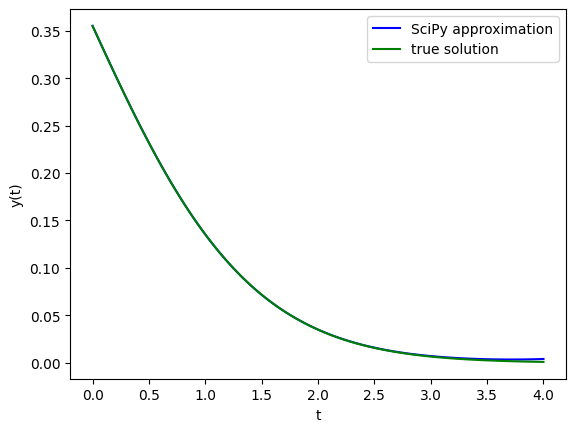

In [ ]:
plt.plot(airy_scipy.t, airy_scipy.y[1], label='SciPy approximation', color='blue')
plt.plot(airy_scipy.t, airy(airy_scipy.t)[0], label='true solution', color='green')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.show()

Let's compare the values of the numerical solution to the exact solution on a point not in the training set, $1.2$ in this case.

In DeepXDE

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.353563 s

'compile' took 1.400179 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.46e-05, 1.26e-03, 4.49e-02]    [6.45e-05, 1.26e-03, 4.49e-02]    [1.13e+00]    
1000      [2.38e-07, 4.60e-10, 3.87e-12]    [2.33e-07, 4.60e-10, 3.87e-12]    [5.66e-03]    
2000      [1.10e-07, 5.95e-11, 2.88e-13]    [1.09e-07, 5.95e-11, 2.88e-13]    [2.99e-03]    
3000      [7.50e-08, 5.21e-12, 6.96e-13]    [7.44e-08, 5.21e-12, 6.96e-13]    [2.97e-03]    
4000      [5.45e-08, 4.45e-12, 3.20e-12]    [5.34e-08, 4.45e-12, 3.20e-12]    [3.10e-03]    
5000      [6.48e-07, 1.85e-10, 2.95e-06]    [6.49e-07, 1.85e-10, 2.95e-06]    [2.21e-02]    
6000      [3.36e-08, 2.72e-11, 2.22e-12]    [3.16e-08, 2.72e-11, 2.22e-12]    [3.94e-03]    
7000      [3.08e-08, 3.67e-11, 7.52e-12]    [2.82e-08, 3.67e-11, 7.52e-12]    [4.20e-03]    
8000      [3.02e-08, 4.18e-11, 1.35e-09]    [2.73e-08, 4.18e-11, 1.35e-09]    [4.68e-03]    

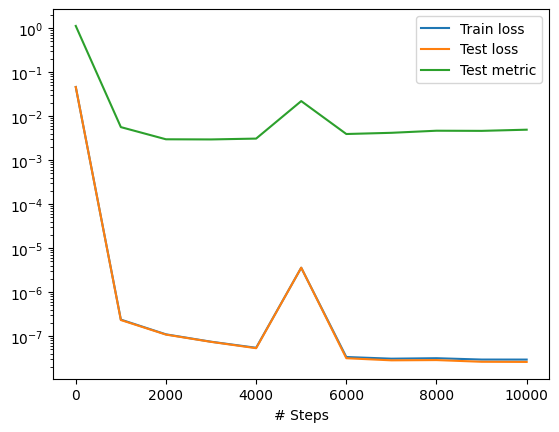

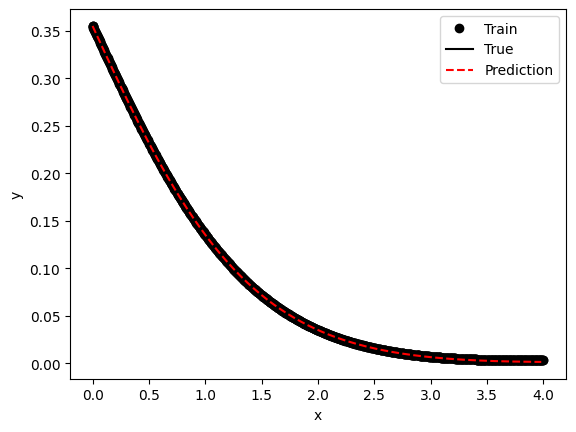

In [ ]:
def airy_deepxde(t, y):
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 - y * t

def airy_ref(t):
    # return airy(t)[0]
    # we'll use the numerical solution as a reference solution
    return airy_scipy.sol(t.flatten())[1].reshape(t.shape[0],t.shape[1])

geom = dde.geometry.TimeDomain(0, 4)

def boundary_l(t, on_initial):
    return on_initial and dde.utils.isclose(t[0], 0)

def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - y0_0

ic1 = dde.icbc.IC(geom, lambda x: y1_0, lambda _, on_initial: on_initial)
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

data = dde.data.TimePDE(geom, airy_deepxde, [ic1, ic2], 1000, 2, solution=airy_ref, num_test=200)

net = dde.nn.FNN([1] + [50] * 3 + [1], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, decay = ("inverse time", 1000, 0.3), metrics=["l2 relative error"], loss_weights=[0.01, 0.01, 1]
)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
model.

OrderedDict([('dense/kernel:0',
              array([[ 0.12566242, -0.11471153,  0.24776629,  0.14087676,  0.26174653,
                      -0.19575003,  0.22239679, -0.32962194,  0.3416231 ,  0.20431809,
                       0.3298646 , -0.32940447, -0.2836149 ,  0.02246534, -0.29215592,
                      -0.2243712 , -0.19956101, -0.17078134, -0.13785127, -0.26771772,
                      -0.20729662,  0.2637319 ,  0.06376187, -0.04052426,  0.13914248,
                       0.18638243,  0.02269037,  0.34108102, -0.07568984,  0.28265518,
                       0.05617791,  0.23440152,  0.23403014,  0.32425648, -0.24368261,
                       0.2255623 ,  0.20556404,  0.0656247 ,  0.15996705,  0.03376802,
                      -0.1268872 ,  0.1615513 , -0.22025928, -0.20872784, -0.26657563,
                       0.1788067 ,  0.20342726, -0.318063  ,  0.13643081,  0.27812096]],
                    dtype=float32)),
             ('dense/bias:0',
              array([-4.14210

<a id="2"></a>
## Lorenz attractor: PINNs partial failure

Consider **Lorenz' system** of equations
\begin{align}
\frac{dx}{dt} & = \sigma(y-x)\\
\frac{dy}{dt} & =x(\rho -z) -y \\
\frac{dz}{dt} & = xy - \beta z\\\tag{5}
\end{align}
with parameters
$$
\sigma=10\quad , \quad \beta=\frac{8}{3} \quad , \quad \rho= 28,
$$
and initial conditions
$$
x(0)= 0\quad , \quad y(0)= 1\quad , \quad z(0)=1.05.
$$


The equations relate the properties of a two-dimensional fluid layer uniformly warmed from below and cooled from above. In particular, the equations describe the rate of change of three quantities with respect to time: $x$ is proportional to the rate of convection, $y$ to the horizontal temperature variation, and $z$ to the vertical temperature variation. The constants $\sigma, \rho$, and $\beta $ are system parameters proportional to the Prandtl number, Rayleigh number, and certain physical dimensions of the layer itself.

In [ ]:
# Lorenz paramters
sigma, beta, rho = 10, 2.667, 28
# initial conditions x(0), y(0) and z(0)
x0, y0, z0 = 0, 1, 1.05

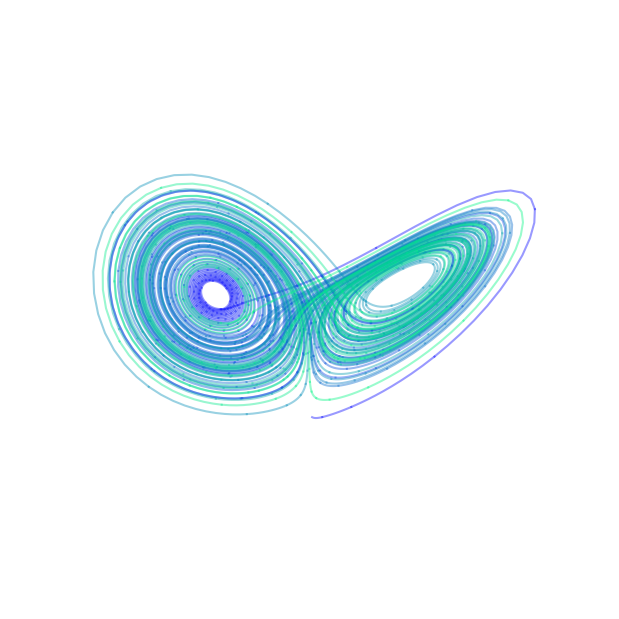

In [ ]:
# Maximum time point and total number of time points.
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma*(y - x)
    dy_dt = rho*x - y - x*z
    dz_dt = -beta*z + x*y
    return dx_dt, dy_dt, dz_dt
# Integrate the Lorenz equations.
lorenz_scipy = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = lorenz_scipy.sol(t)

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)


# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.056028 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.669670 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.51e+00, 7.70e+01, 1.14e-01, 0.00e+00, 1.00e+00, 1.10e+00]    [4.51e+00, 7.70e+01, 1.14e-01, 0.00e+00, 1.00e+00, 1.10e+00]    []  
1000      [4.41e-05, 4.54e-05, 4.29e-05, 2.60e-06, 7.00e-10, 1.55e-09]    [4.41e-05, 4.54e-05, 4.29e-05, 2.60e-06, 7.00e-10, 1.55e-09]        
1143      [1.50e-05, 3.21e-05, 8.22e-06, 2.19e-08, 6.42e-09, 3.61e-09]    [1.50e-05, 3.21e-05, 8.22e-06, 2.19e-08, 6.42e-09, 3.61e-09]    []  

Best model at step 1143:
  train loss: 5.54e-05
  test loss: 5.54e-05
  test metric: []

'train' took 10.221476 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


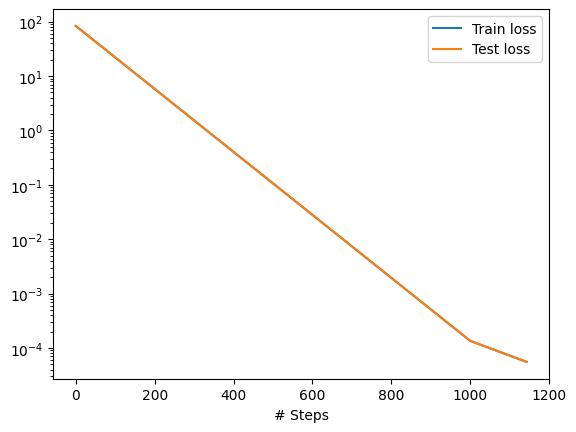

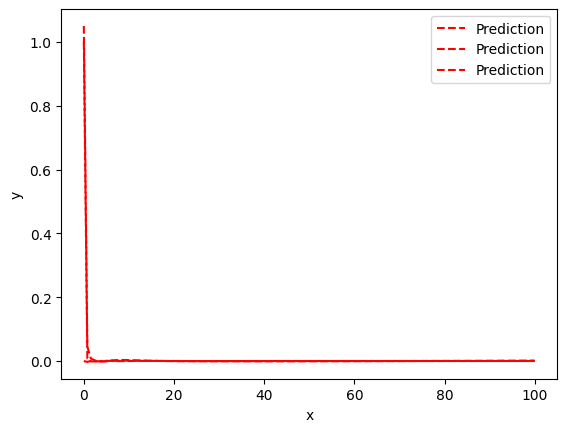

In [ ]:
def lorenz_deepxde(t, u):
    x = u[:, 0:1]
    y = u[:, 1:2]
    z = u[:, 2:3]
    dx_dt = dde.grad.jacobian(u, t, i=0)
    dy_dt = dde.grad.jacobian(u, t, i=1)
    dz_dt = dde.grad.jacobian(u, t, i=2)
    return [dx_dt - sigma*(y - x), dy_dt - rho*x + y + x*z, dz_dt + beta*z - x*y]

# the reference function
def lorenz_ref(t):
    x, y, z = lorenz_scipy.sol(t.flatten())
    return np.vstack((x, y, z)).T

geom = dde.geometry.TimeDomain(0., 100.)

def boundary(t, on_initial):
    return dde.utils.isclose(t[0], 0.0)

# initial conditions
ic1 = dde.icbc.IC(geom, lambda t: x0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda t: y0, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda t: z0, boundary, component=2)

data = dde.data.PDE(
    geom, lorenz_deepxde, [ic1, ic2, ic3],
    num_domain=1500,
    num_boundary=100,
    )

net = dde.nn.FNN([1] + [50]*3 + [3],
        activation="tanh",
        kernel_initializer="Glorot uniform",
      )

model = dde.Model(data, net)

model.compile(
    optimizer = "L-BFGS", lr=1e-4,
    # decay = ("inverse time", 1000, 0.3),
)

losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Let's compare the predicted solution to the reference solution obtained from SciPy.

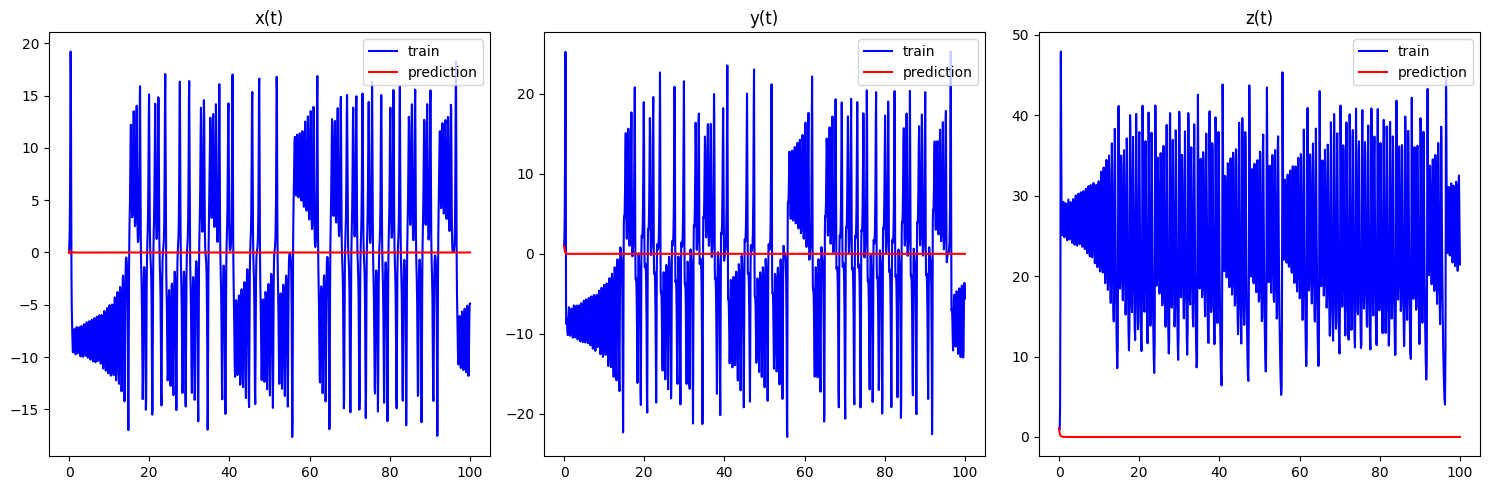

In [ ]:
# The predicted solution using DeepXDE
lorenz_predict = model.predict(lorenz_scipy.t.reshape(lorenz_scipy.t.shape[0],1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# x(t)
axs[0].plot(lorenz_scipy.t, lorenz_scipy.y[0], label='train', color='b')
axs[0].plot(lorenz_scipy.t, lorenz_predict[:,0], label='prediction', color='red')
axs[0].set_title('x(t)')
axs[0].legend()

# y(t)
axs[1].plot(lorenz_scipy.t, lorenz_scipy.y[1], label='train', color='b')
axs[1].plot(lorenz_scipy.t, lorenz_predict[:,1], label='prediction', color='red')
axs[1].set_title('y(t)')
axs[1].legend()

# z(t)
axs[2].plot(lorenz_scipy.t, lorenz_scipy.y[2], label='train', color='b')
axs[2].plot(lorenz_scipy.t, lorenz_predict[:,2], label='prediction', color='red')
axs[2].set_title('z(t)')
axs[2].legend()

plt.tight_layout()

plt.show()


### Question
Plot 3D trajectory of the resulting PINN solution to the Lorenz system. You can modify the code snippet below

In [ ]:
#@title Code snippet

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)


# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

<a id="3"></a>
## Kepler problem: PINNs loss of accuracy

### Two-body system

The 2D **Kepler problem** describes the motion of two point masses under the influence of gravitational attraction in a two-dimensional plane. Let's call the two masses $m_1$ and $m_2$, and let $\vec{r_1}$ and $\vec{r_2}$ be the radial vectors from the origin $O$, as in the picture below.

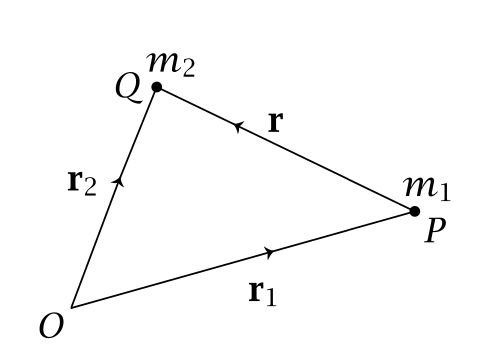

The motion of $m_1$ and $m_2$ is described by the two differential equations
\begin{equation}
\frac{d^2 r_1}{dt^2} =  \frac{G m_2}{r^3}\vec{r} \qquad \text{and} \qquad \frac{d^2 r_2}{dt^2} =  -\frac{G m_1}{r^3}\vec{r},\tag{6}
\end{equation}
where $\vec{r} = \vec{r_2}-\vec{r_1}$ and $r=|\vec{r}|$.

Write $r_1=(x_1,y_1)$ and $r_2=(x_2,y_2)$. Then  (6) is equivalent to  
 $$\begin{cases}
\ddot{x}_1 = G m_2 \frac{x_2 - x_1}{r^3} \\
\ddot{y}_1 = G m_2 \frac{y_2 - y_1}{r^3}
 \end{cases}\quad \text{and} \quad
   \begin{cases} \ddot{x}_2 = -G m_1 \frac{x_2 - x_1}{r^3} \\
    \ddot{y}_2 = -G m_1 \frac{y_2 - y_1}{r^3} .
   \end{cases}\tag{7}$$


We impose the initial positions
$$
r_1(0)=(0,0) \qquad , \qquad r_2(0)=(0,0.2)
,$$
and initial velocities
$$
\dot{r_1}(0)=(0,1) \qquad , \qquad \dot{r_2}(0)=(0,-1)
.$$

Consider the state vector $$s = \left[x_1\ y_1\ x_2\ y_2\ \dot{x}_1\ \dot{y}_1\ \dot{x}_2\ \dot{y}_2\right],$$
and its derivative
$$
\dot{s} = \left[\dot{x}_1\ \dot{y}_1\ \dot{x}_2\ \dot{y}_2\ \ddot{x}_1\ \ddot{y}_1\ \ddot{x}_2\ \ddot{y}_2\right].
$$

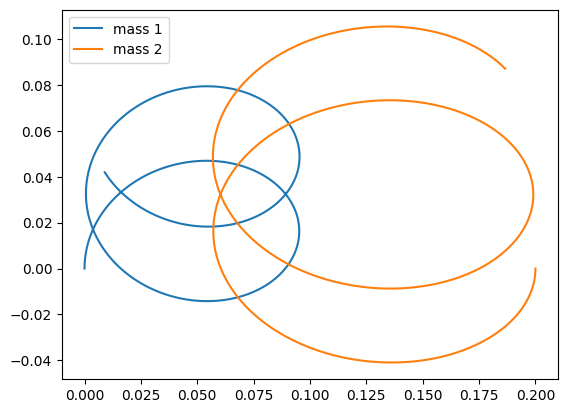

In [ ]:
G = 1.0  # physical constant ~ 6.67430e-20
m_1, m_2 = 1.5, 1.0

r_1_0 = np.array((0, 0))        # initial loc r1
r_2_0 = np.array((0.2, 0))      # initial loc r2
dotr_1_0 = np.array((0, 1))   # initial vel r1
dotr_2_0 = np.array((0, -1))    # initial vel r2

# the initial condition
s0 = np.hstack((r_1_0, r_2_0, dotr_1_0, dotr_2_0))

# the equations
def kepler_system(t, s):
  """
  s is the state vector and it has 8 components,
  the first four represent r_1 (the position vector of m_1),
  and the last four represent r_2 (the position vector of m_2)
  """
  r_1 = s[:2]
  r_2 = s[2:4]

  # define the derivative of the state vector
  sdot = np.zeros_like(s)
  sdot[:4] = s[4:]

  r = np.linalg.norm(r_2 - r_1)
  ddot = G * (r_2 - r_1) / r ** 3
  ddotr_1 = m_2 * ddot
  ddotr_2 = -m_1 * ddot

  sdot[4:6] = ddotr_1
  sdot[6:] = ddotr_2
  return sdot

t_0 = 0  # seconds
t_f = 0.3  # seconds
t_points = np.linspace(t_0, t_f, 10000)

kepler_scipy = solve_ivp(kepler_system, [t_0, t_f], s0, t_eval=t_points, dense_output=True)

t = kepler_scipy.t
s = kepler_scipy.y
r_1 = s[:2,:]  # km
r_2 = s[2:4,:]  # km
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r_1[0,:], r_1[1,:], label="mass 1")
ax.plot(r_2[0,:], r_2[1,:], label="mass 2")
ax.legend()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.107492 s

'compile' took 6.380333 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric   
0         [1.22e+01, 2.34e+01, 5.38e+01, 4.02e+01, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]    [1.27e+01, 2.69e+01, 5.34e+01, 4.83e+01, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]    [1.10e+00]    
5000      [1.25e-02, 6.61e-02, 1.47e-02, 9.22e-02, 1.03e-03, 3.79e-01, 7.74e-04, 3.85e-01]    [1.49e-02, 8.03e-02, 1.59e-02, 1.14e-01, 1.03e-03, 3.79e-01, 7.74e-04, 3.85e-01]    [7.36e-01]    
10000     [1.91e-02, 4.44e-02, 3.06e-02, 4.62e-02, 7.92e-05, 2.71e-01, 7.28e-07, 2.70e-01]    [2.36e-02, 5.48e-02, 3.71e-02, 5.58e-02, 7.92e-05, 2.71e-01, 7.28e-07, 2.70e-01]    [6.30e-01]    
15000     [2.47e-02, 3.73e-02, 3.38e-02, 3.98e-02, 3.95e-05, 2.01e-01, 9.73e-05, 2.03e-01]    [3.0

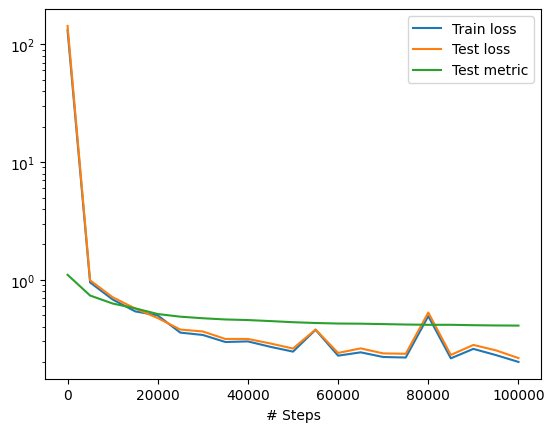

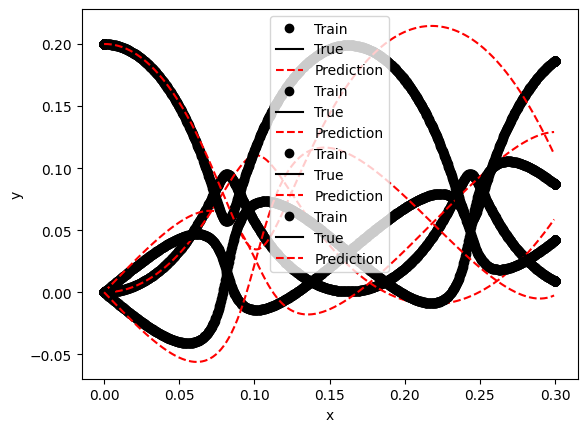

In [ ]:
def kepler_deepxde(t, s):
    # s=[x1,y1,x2,y2]
    x1, y1, x2, y2 = s[:,0:1], s[:,1:2], s[:,2:3], s[:,3:4]
    r = tf.norm(s[:,0:2] - s[:,2:4], axis=1, keepdims=True)

    # equations in (7)
    z1 = dde.grad.hessian(x1, t) - G*m_2*(x2-x1) / r**3
    z2 = dde.grad.hessian(y1, t) - G*m_2*(y2-y1) / r**3
    z3 = dde.grad.hessian(x2, t) + G*m_1*(x2-x1) / r**3
    z4 = dde.grad.hessian(y2, t) + G*m_1*(y2-y1) / r**3

    return [z1, z2, z3, z4]

def boundary_ic(t, on_initial):
    return dde.utils.isclose(t[0], 0.0)

# velocity initial conditions
def bc_func1(t, y, _):
    # x_1'(0)
    return dde.grad.jacobian(y, t, i=0) - dotr_1_0[0]
def bc_func2(t, y, _):
    # y_1'(0)
    return dde.grad.jacobian(y, t, i=1) - dotr_1_0[1]
def bc_func3(t, y, _):
    # x_2'(0)
    return dde.grad.jacobian(y, t, i=2) - dotr_2_0[0]
def bc_func4(t, y, _):
    # y_2'(0)
    return dde.grad.jacobian(y, t, i=3) - dotr_2_0[1]

def kepler_ref(t):
    return kepler_scipy.sol(t.flatten()).T[:, 0:4]

# position initial conditions
geom = dde.geometry.TimeDomain(t_0, t_f)

bc1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_ic)
bc2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_ic)
bc3 = dde.icbc.OperatorBC(geom, bc_func3, boundary_ic)
bc4 = dde.icbc.OperatorBC(geom, bc_func4, boundary_ic)

ibc = [bc1, bc2, bc3, bc4]

def output_transform_hard_IC(t, y):
    x1, y1 = y[:, 0:1], y[:, 1:2]
    x2, y2 = y[:, 2:3], y[:, 3:4]

    factor = tf.tanh(t)

    return tf.concat([x1 * factor + r_1_0[0],
                      y1 * factor + r_1_0[1],
                      x2 * factor + r_2_0[0],
                      y2 * factor + r_2_0[1]],
                      axis=-1)

net = dde.nn.FNN([1] + [50] * 4 + [4], "sin", "He normal")
net.apply_output_transform(output_transform_hard_IC)  # initial conditions are applied as hard constraints

data = dde.data.TimePDE(
    geom, kepler_deepxde,
    ic_bcs=ibc,
    num_domain=1000,
    num_boundary=250,
    solution=kepler_ref,
    num_test=500,
)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3,
              loss_weights=[1e-1]*4 + [1]*4,
              metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=100000, display_every=5000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

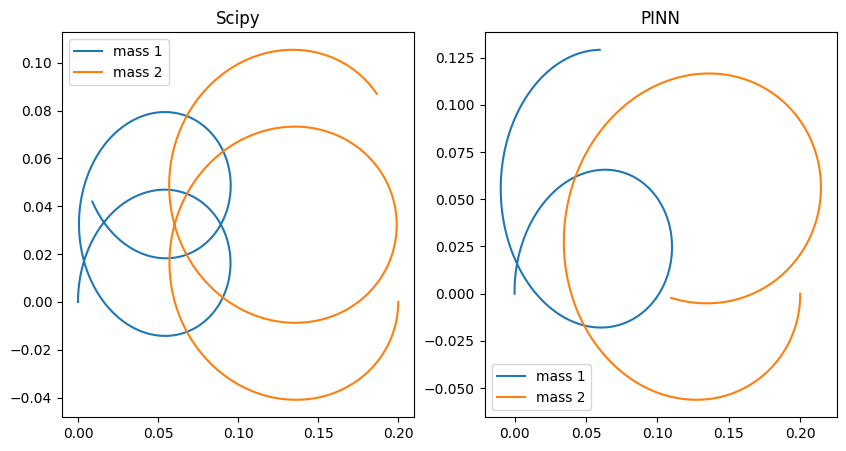

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

t = kepler_scipy.t
s = kepler_scipy.y
r_1 = s[:2,:]  # km
r_2 = s[2:4,:]  # km

ax.plot(r_1[0,:], r_1[1,:], label="mass 1")
ax.plot(r_2[0,:], r_2[1,:], label="mass 2")
ax.set_title("Scipy")
ax.legend()

ax = fig.add_subplot(122)

s = model.predict(t[:, None])
r_1 = s[:, :2]  # km
r_2 = s[:, 2:4]  # km

ax.set_title("PINN")
ax.plot(r_1[:, 0], r_1[:, 1], label="mass 1")
ax.plot(r_2[:, 0], r_2[:, 1], label="mass 2")
ax.legend()

plt.show()

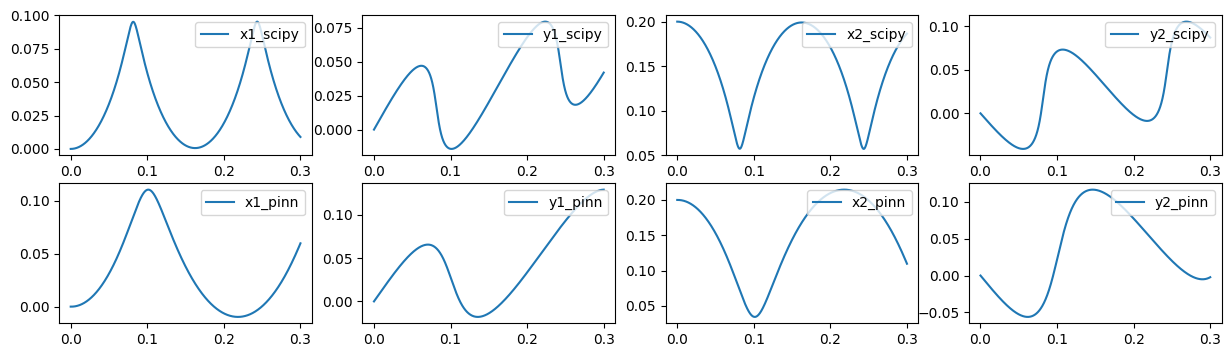

In [ ]:
fig = plt.figure(figsize=(15,4))

leg_loc = 'upper right'
t = kepler_scipy.t
s = kepler_scipy.y

ax = fig.add_subplot(241)
ax.plot(t, s[0,:], label="x1_scipy")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(242)
ax.plot(t, s[1,:], label="y1_scipy")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(243)
ax.plot(t, s[2,:], label="x2_scipy")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(244)
ax.plot(t, s[3,:], label="y2_scipy")
ax.legend(loc=leg_loc)

s = model.predict(t[:, None])

ax = fig.add_subplot(245)
ax.plot(t, s[:, 0], label="x1_pinn")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(246)
ax.plot(t, s[:, 1], label="y1_pinn")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(247)
ax.plot(t, s[:, 2], label="x2_pinn")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(248)
ax.plot(t, s[:, 3], label="y2_pinn")
ax.legend(loc=leg_loc)

plt.show()

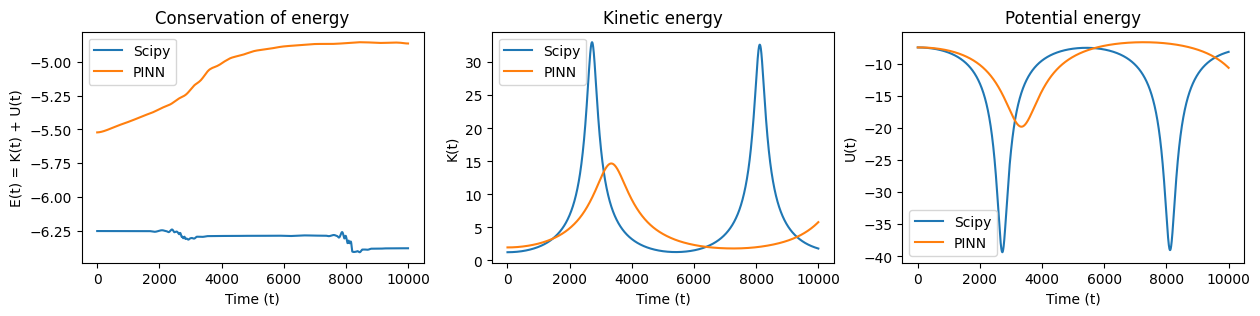

In [ ]:
def total_energy(t, s):
    x1, y1, x2, y2 = s[:,0:1], s[:,1:2], s[:,2:3], s[:,3:4]
    r = tf.norm(s[:, 0:2] - s[:, 2:4], axis=1, keepdims=True)

    # velocity
    vx1 = dde.grad.jacobian(x1, t)
    vy1 = dde.grad.jacobian(y1, t)
    vx2 = dde.grad.jacobian(x2, t)
    vy2 = dde.grad.jacobian(y2, t)

    K = 0.5 * (m_1 * (vx1**2 + vy1**2) + m_2 * (vx2**2 + vy2**2))
    U = - G * m_1 * m_2 / r

    return K, U

K_dde, U_dde = model.predict(t[:, None], operator=total_energy)
K_dde, U_dde = K_dde.squeeze(), U_dde.squeeze()

def total_energy_scipy(scipy_solution):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = scipy_solution
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    K = 0.5 * (m_1 * (vx1**2 + vy1**2) + m_2 * (vx2**2 + vy2**2))
    U = - G * m_1 * m_2 / r

    return K, U

K_scipy, U_scipy = total_energy_scipy(kepler_scipy.y)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(K_scipy + U_scipy, label='Scipy')
plt.plot(K_dde + U_dde, label='PINN')
plt.title('Conservation of energy')
plt.xlabel('Time (t)')
plt.ylabel('E(t) = K(t) + U(t)')
plt.legend()

plt.subplot(132)
plt.plot(K_scipy, label='Scipy')
plt.plot(K_dde, label='PINN')
plt.title('Kinetic energy')
plt.xlabel('Time (t)')
plt.ylabel('K(t)')
plt.legend()

plt.subplot(133)
plt.plot(U_scipy, label='Scipy')
plt.plot(U_dde, label='PINN')
plt.title('Potential energy')
plt.xlabel('Time (t)')
plt.ylabel('U(t)')
plt.legend()

plt.show()

### Single-body equation

In this second example, we compute the  motion of mass $m_2$ relative to mass $m_1$. For example, $m_1$ represents earth and $m_2$ represents a satellite. The equation of motion is given by

$$ \frac{d^2\vec{r}}{dt^2} = -Gm_1\frac{\vec{r}}{r^3}.$$

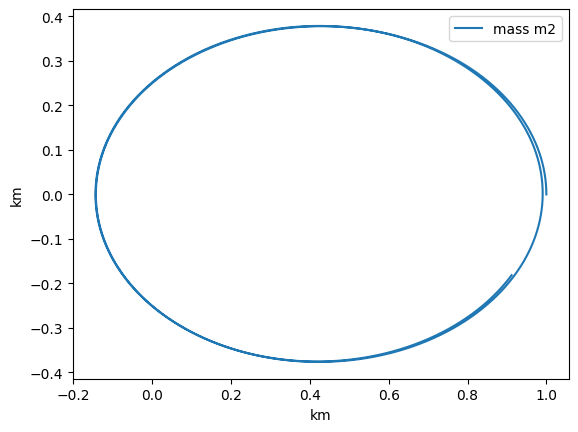

In [ ]:
G = 1  # km**3/(kg * s**2)
m_1 = 1e2  # kg
m_2 = 1e-2  # kg
mu = G * m_1

r_0 = np.array((1, 0))  # km
v_0 = np.array((0, 5.0))  # km/s
y_0 = np.hstack((r_0, v_0))

def kepler_single(t, y):

    # Get the three position components
    r_vec = y[:2]

    # Create the derivative vector and copy the velocities into it
    ydot = np.zeros_like(y)
    ydot[:2] = y[2:]

    # Calculate the accelerations
    r = np.sqrt(np.sum(np.square(r_vec)))
    a_vec = -mu * r_vec / r ** 3
    ydot[2:] = a_vec

    return ydot

t_0 = 0  # seconds
t_f = 0.5  # seconds, period of one orbit
t = np.linspace(t_0, t_f, 10000)
sol_kepler_single = solve_ivp(kepler_single, [t_0, t_f], y_0, t_eval=t, dense_output=True)

y = sol_kepler_single.y.T
r = y[:, :2]  # km
v = y[:, 2:]  # km/s

plt.plot(r[:, 0], r[:, 1], label="mass m2")
plt.xlabel("km")
plt.ylabel("km")

plt.legend()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.073947 s

'compile' took 1.634011 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [8.96e+02, 2.35e-01, 0.00e+00, 2.50e+01]    [9.00e+02, 2.18e-01, 0.00e+00, 2.50e+01]    [7.06e-01]    
2500      [1.16e+00, 4.17e+00, 3.23e-01, 1.02e+01]    [1.02e+00, 4.47e+00, 3.23e-01, 1.02e+01]    [1.42e+00]    
5000      [9.62e-01, 3.15e+00, 3.65e-01, 7.81e+00]    [9.91e-01, 3.21e+00, 3.65e-01, 7.81e+00]    [1.25e+00]    
7500      [6.83e-01, 2.87e+00, 2.47e-01, 6.96e+00]    [6.70e-01, 3.00e+00, 2.47e-01, 6.96e+00]    [1.18e+00]    
10000     [3.97e+00, 4.12e+00, 2.05e-01, 5.31e+00]    [4.19e+00, 4.46e+00, 2.05e-01, 5.31e+00]    [1.08e+00]    
12500     [4.56e-01, 2.02e+00, 1.17e-01, 4.82e+00]    [4.84e-01, 2.16e+00, 1.17e-01, 4.82e+00]    [1.04e+00]    
15000     [1.63e+00, 3.87e+00, 8.54e-02, 4.40e+00]    [1.76e+00, 4.16e+00, 8.54

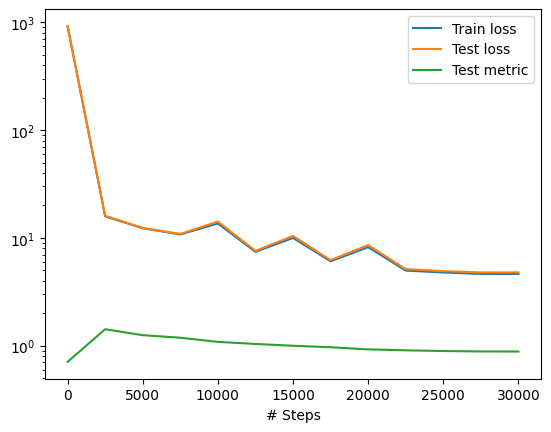

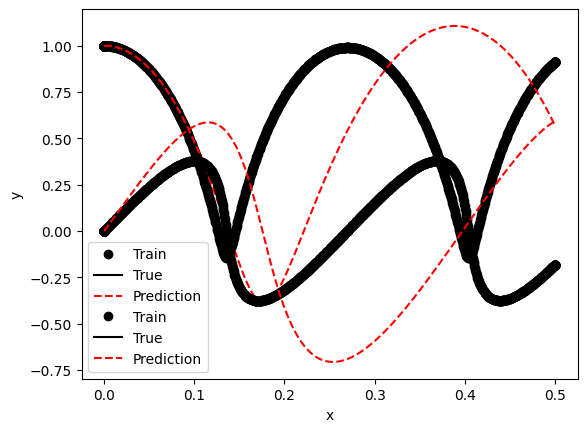

In [ ]:
def kepler_single_deepxde(t, y):
    r = tf.norm(y, axis=1, keepdims=True)
    y0_tt = dde.grad.hessian(y, t, component=0)
    y1_tt = dde.grad.hessian(y, t, component=1)
    return [y0_tt + mu * y[:, 0:1] / r**3,
            y1_tt + mu * y[:, 1:2] / r**3]

def boundary_bc(t, on_initial):
    return dde.utils.isclose(t[0], 0.0)

# velocity initial conditions
def bc_func1(t, y, _):
    # x_1'(0)
    return dde.grad.jacobian(y, t, i=0) - v_0[0]
def bc_func2(t, y, _):
    # y_1'(0)
    return dde.grad.jacobian(y, t, i=1) - v_0[1]

def kepler_ref(t):
    return sol_kepler_single.sol(t.flatten())[:2].T

# position initial conditions
geom = dde.geometry.TimeDomain(t_0, t_f)

bc1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_bc)
bc2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_bc)

ibc = [bc1, bc2]

data = dde.data.TimePDE(
    geom, kepler_single_deepxde,
    ic_bcs=ibc,
    num_domain=1000,
    num_boundary=100,
    solution=kepler_ref,
    num_test=500,
)

def output_transform_hard_IC(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    factor = tf.tanh(t)
    return tf.concat([y1 * factor + r_0[0],
                      y2 * factor + r_0[1]], axis=1)

net = dde.nn.FNN([1] + [50] * 4 + [2], "sin", "Glorot uniform")
net.apply_output_transform(output_transform_hard_IC)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3,
              loss_weights=[1e-1]*2 + [1]*2,
              metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=30000, display_every=2500)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

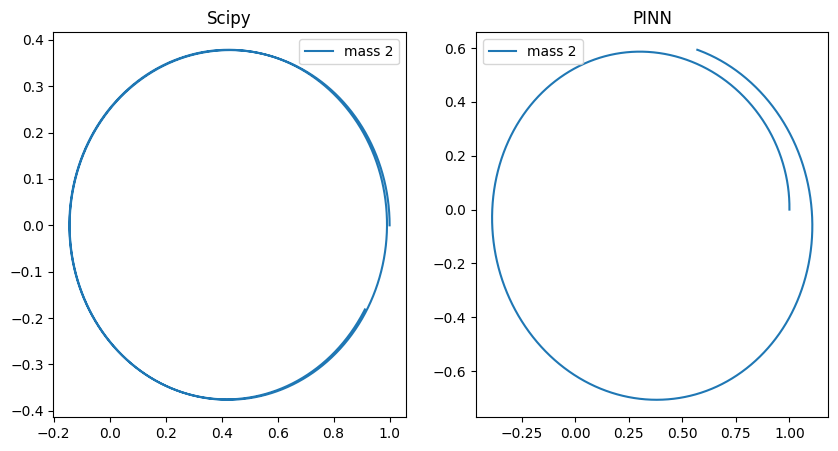

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

t = sol_kepler_single.t
s = sol_kepler_single.y
r_1 = s[:2,:]  # km

ax.plot(r_1[0,:], r_1[1,:], label="mass 2")
ax.set_title("Scipy")
ax.legend()

ax = fig.add_subplot(122)

s = model.predict(t[:, None])

ax.set_title("PINN")
ax.plot(s[:, 0], s[:, 1], label="mass 2")
ax.legend()

plt.show()

### Question
Calculate and plot the total energy of single body system (see example above on the two body system)

In [ ]:
#@title ###Answer

def total_energy(t, y):
    x1, y1 = y[:, 0:1], y[:, 1:2]
    r = tf.norm(y, axis=1, keepdims=True)

    # velocity
    vx1 = dde.grad.jacobian(x1, t)
    vy1 = dde.grad.jacobian(y1, t)

    K = 0.5 * (m_2 * (vx1**2 + vy1**2))
    U = - G * m_1 * m_2 / r

    return K, U

K_dde, U_dde = model.predict(t[:, None], operator=total_energy)
K_dde, U_dde = K_dde.squeeze(), U_dde.squeeze()

def total_energy_scipy(scipy_solution):
    x1, y1, vx1, vy1 = scipy_solution
    r = np.sqrt(x1**2 + y1**2)

    K = 0.5 * m_2 * (vx1**2 + vy1**2)
    U = - G * m_1 * m_2 / r

    return K, U

K_scipy, U_scipy = total_energy_scipy(sol_kepler_single.y)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(K_scipy + U_scipy, label='Scipy')
plt.plot(K_dde + U_dde, label='PINN')
plt.title('Conservation of energy')
plt.xlabel('Time (t)')
plt.ylabel('E(t) = K(t) + U(t)')
plt.legend()

plt.subplot(132)
plt.plot(K_scipy, label='Scipy')
plt.plot(K_dde, label='PINN')
plt.title('Kinetic energy')
plt.xlabel('Time (t)')
plt.ylabel('K(t)')
plt.legend()

plt.subplot(133)
plt.plot(U_scipy, label='Scipy')
plt.plot(U_dde, label='PINN')
plt.title('Potential energy')
plt.xlabel('Time (t)')
plt.ylabel('U(t)')
plt.legend()

plt.show()

## Lotka-Volterra equations



Consider the Lotka-Volterra equations, also known as the Lotka-Volterra predator-prey model:
$$
\begin{cases}
\frac{d x}{dt}= \alpha x - \beta xy \\
\frac{d y}{dt} = - \gamma y + \delta xy .
\end{cases}
$$

Set the parameters  $(\alpha, \beta, \gamma, \delta ) = (2/3, 4/3, 1, 1)$:

In [ ]:
alpha = 0.66
beta = 1.33
delta = 1.
gamma = 1.

and the initial values $x(0) = 1, y(0) = 1$:

In [ ]:
x0 = 1
y0 = 1

We compute a numerical solution using  the method `solve_ivp` in SciPy.

In [ ]:
def Lotka_Voltera_func(t, q):
    x, y = q
    dx_t = alpha*x - beta*x*y
    dy_t = delta*x*y - gamma*y
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = solve_ivp(Lotka_Voltera_func, (0, 10), (x0, y0), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true

We can drop time from the model to reduce the model into a single differential equation

$$
\frac{dy}{dx} =\frac{-y}{x}\frac{ \delta x -\gamma}{ \beta y - \alpha}.
$$

Separating the variables, we get
$$
\frac{\beta y - \alpha}{y}dy + \frac{\delta x - \gamma}{x}dx=0.$$

Integrating this leads to the equation of phase curves

$$\delta x - \gamma \log(x) +\beta y - \alpha \log(y)=C,$$
for $C= \delta x_0 - \gamma \log(x_0) +\beta y_0 - \alpha \log(y_0).$

Let's plot the phase-curve of the solution.

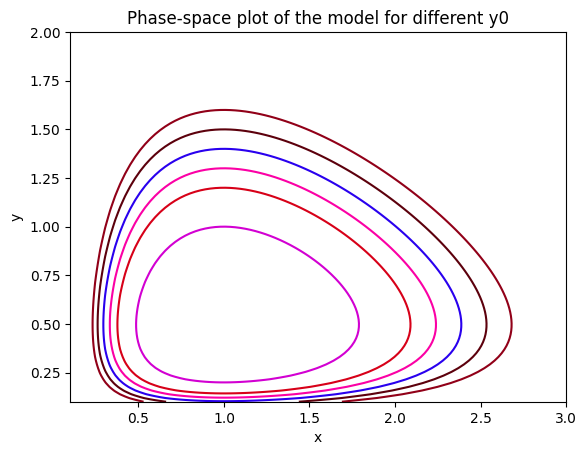

In [ ]:
C = delta*x0 - gamma*np.log(x0) + beta*y0 - alpha*np.log(y0)
def phase_cuve(x, y, y0):
    C = delta*x0 - gamma*np.log(x0) + beta*y0 - alpha*np.log(y0)
    return delta*x - gamma*np.log(x) + beta*y - alpha*np.log(y) - C

x = np.linspace(0.1, 3., 100)
y = np.linspace(0.1, 2., 100)

X, Y = np.meshgrid(x, y)
for y0 in [1, 1.2, 1.3, 1.4, 1.5, 1.6]:
    Z = phase_cuve(X, Y, y0)
    plt.contour(X, Y, Z, levels=[0], colors=[(100*np.sin(y0), 0, 100*np.cos(y0))])

plt.xlabel("x")
plt.ylabel("y")
plt.title("Phase-space plot of the model for different y0")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.171665 s

'compile' took 1.796449 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.16e+02, 1.09e+00]    [2.16e+02, 1.09e+00]    []  
1000      [5.35e+00, 3.97e-01]    [5.21e+00, 3.96e-01]    []  
2000      [3.31e+00, 5.84e-01]    [3.18e+00, 5.78e-01]    []  
3000      [2.11e+00, 6.83e-01]    [2.00e+00, 6.70e-01]    []  
4000      [1.81e+00, 8.10e-01]    [1.72e+00, 7.92e-01]    []  
5000      [1.24e+00, 6.30e-01]    [1.18e+00, 6.14e-01]    []  
6000      [6.77e-01, 4.43e-01]    [6.35e-01, 4.30e-01]    []  
7000      [1.29e+01, 4.24e-01]    [1.27e+01, 4.21e-01]    []  
8000      [7.55e+00, 3.62e-01]    [7.42e+00, 3.64e-01]    []  
9000      [5.56e+00, 4.12e-01]    [5.40e+00, 4.09e-01]    []  
10000     [4.19e+00, 4.06e-01]    [4.03e+00, 4.00e-01]    []  
11000     [3.07e+00, 5.63e-01]    [2.93e+00, 5.54e-01]    []  
12000     [1.84e+00, 6.48e-01]    [1.73e+00,

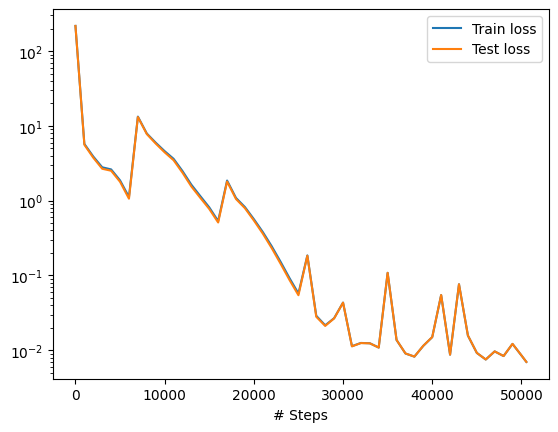

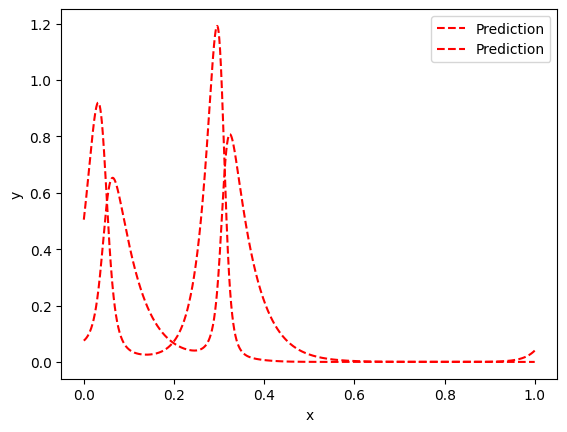

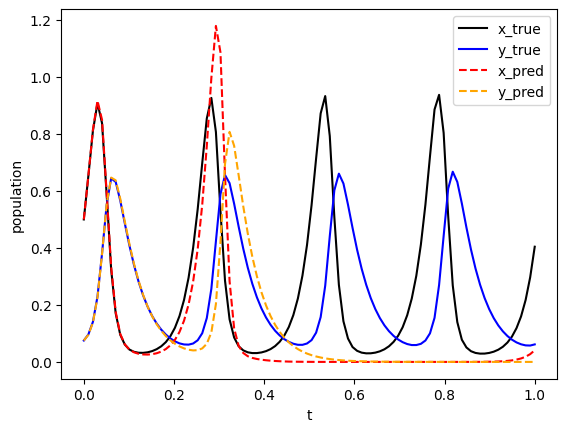

In [ ]:
def Lotka_Voltera_eq(t, q):
    x = q[:, 0:1]
    y = q[:, 1:2]
    dx_t = dde.grad.jacobian(q, t, i=0)
    dy_t = dde.grad.jacobian(q, t, i=1)
    return [
        dx_t - alpha*x + beta*x*y,
        dy_t - delta*x*y + gamma*y
    ]

geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, Lotka_Voltera_eq, [], 3000, 2, num_test=3000)

net = dde.nn.FNN([1] + [64] * 6 + [2], "tanh", "Glorot normal")

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )

def output_transform(t, q):
    x = q[:, 0:1]
    y = q[:, 1:2]
    return tf.concat([x * tf.tanh(t) + x0, y * tf.tanh(t) + y0], axis=1)

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

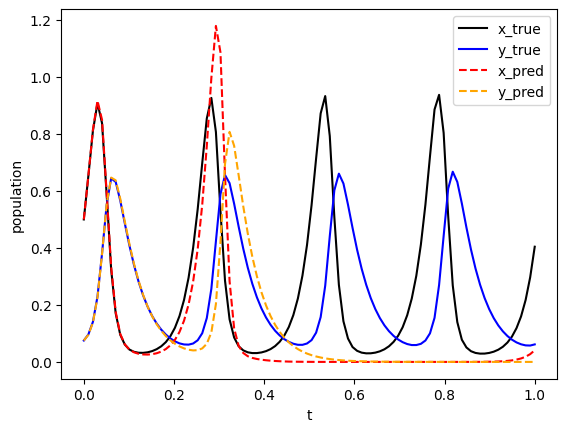

In [ ]:
plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

### Question

You may try to change neural network architecture (number of layers, neurons, activation function). Modify this part in the code above:
``` python
net = dde.nn.FNN([1] + [64] * 6 + [2], "tanh", "Glorot normal")
```

<a id="10"></a>
# Part 2: Partial differential equations

<a id="4"></a>
## The wave equation

Consider the scalar wave equation  
\begin{equation}
\frac{\partial^2 u}{\partial t^2} =  c \frac{\partial^2 u}{\partial x^2},
\tag{7}
\end{equation}
with initial conditions
$$
u(x, 0) = 0 \qquad \text{and} \qquad u_t(x,0) =\phi(x),
$$
where $u=u(x,t)$ and $c$ is a non-negative real number.


Using **finite differences**, we get an approximation of the equation

$$  \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta t^2}\approx c  \frac{ u_{i,j+1} - 2u_{i,j} + u_{i,j-1} }{\Delta x^2} .\tag{8}
$$


For convenience, denote $u_{i-1,j},\, u_{i,j}$ and $u_{i+1,j}$, resp., by $v_{j}^{(0)},\, v_{j}^{(1)}$ and $v_{j}^{(2)}$. These represent the values of the solution at three consecutive points in time. Given $ v_{j}^{(0)}$ and $ v_{j}^{(1)}$, we want to find $v_{j}^{(2)}$. Solving for $v_{j}^{(2)}$, we get

$$v_{j}^{(2)} \approx c\frac{\Delta t^2}{\Delta x^2} \left( v_{j-1}^{(1)}-2v_{j}^{(1)} +v_{j+1}^{(1)}\right) +2 v_{j}^{(1)}-v_{j}^{(0)}.\tag{9}$$

We will implement in Python a function  that computes $v_{j}^{(2)}$ from $v_{j}^{(0)}$ and $ v_{j}^{(1)}$ using this formula.

As for the second initial condition, we use the approximation

 $$
u_t(x, 0) \approx \frac{u(x, \Delta t) - u(x,0)}{\Delta t}.
$$
Since $u(x, 0)=0$, we get
$$
u(x, \Delta t) \approx u_t(x,0) \Delta t = \phi(x)\Delta t.
$$

Let's write a function in Python that implements formual (9).

In [ ]:
c = 1
# Define the grid parameters
n_t = 100
n_x = 100  # Number of grid points in the x-direction


# the grid spacing
dt = 1
dx = 1
r = (dt/dx)**2 * c

def wave_eq(t):
    n = int(t/dt)
    # an array where the time component is of length three
    # to represent the past, present and future  (i-1, i, and i+1)
    # this contains the 1st initial condition v[0]
    v = np.zeros((3,n_x))
    U = np.zeros((n,n_x))
    x = np.linspace(-np.pi, np.pi, n_x)

    # 2nd initial condition
    # with phi(x,y)=..
    v[1] = np.cos(np.pi*x)

    # compute v[2] using the formula (9)
    v[2,1:-1] = (v[1,0:-2] -2*v[1,1:-1] + v[1,2:])*r + 2*v[1,1:-1] - v[0,1:-1]
    for iter in range(n):
        v[0] = v[1]
        v[1] = v[2]

        v[2,1:-1] = (v[1,0:-2] -2*v[1,1:-1] + v[1,2:])*r + 2*v[1,1:-1] - v[0,1:-1]

        # record the wave u(x,k) for k=0,..,t*dt in an array U
        U[iter] = v[0]

    return v[0], U

Visualize the output $u(x,t)$ for $t=0,\ldots,5$.

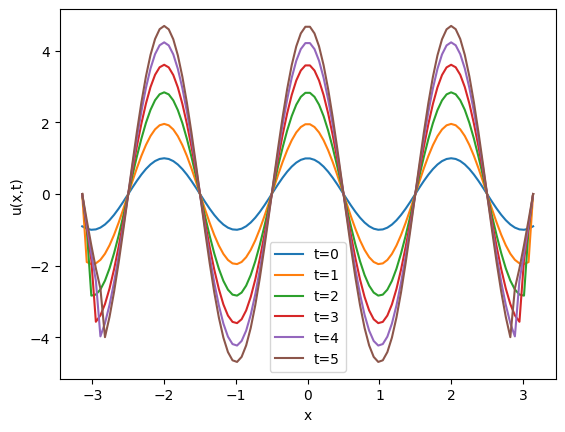

In [ ]:
U = wave_eq(6)[1]
for i in range(6):
    plt.plot(np.linspace(-np.pi,np.pi,100), U[i], label="t={}".format(i))

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

In [ ]:
L = 4  # Length of the spatial domain
T = 1   # Total simulation time
Nx = 100  # Number of spatial grid points
Nt = 100  # Number of time steps

x = np.linspace(0, L, Nx)

# initial conditions
u0 = np.sin(np.pi / L * x)
u_t0 = np.zeros_like(x)

# initial conditions
y0 = np.hstack([u0, u_t0])

# compute the laplacian using the finite diffence method
def laplacian(y):
    y_xx = np.zeros_like(y)
    y_xx[1:-1] = (y[:-2] - 2 * y[1:-1] + y[2:]) / (x[1]-x[0])**2
    return y_xx

# the wave equation as a system of ODEs
def wave_equation(t, y):
    u = y[:Nx]
    u_t = y[Nx:]
    u_xx = laplacian(u)
    return np.hstack([u_t, u_xx])

solution = solve_ivp(
    wave_equation,
    t_span=[0, T],
    y0=y0,
    t_eval=np.linspace(0, T, Nt),
    method='RK45')

Next, we code the wave function in DeepXDE.

In [ ]:
c = 1.0
L = 4

def wave_deepxde(x, y):
    u_xx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    u_tt = dde.grad.hessian(y, x, i=1, j=1, component=0)
    return u_tt - u_xx*c

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
# important!!! make sure that the space variable comes first in your deepxde implementation
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_ic(X, _):
    return dde.utils.isclose(X[1], 0.0)
def boundary_bc(X, _):
    return dde.utils.isclose(X[0], 0.0) or dde.utils.isclose(X[0], L)

ic = dde.icbc.IC(geomtime, lambda x: 0.0, boundary_ic)

bc = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1) - tf.sin(np.pi * x[:,0:1] / L),
    boundary_ic,
    )

data = dde.data.TimePDE(
    geomtime, wave_deepxde, ic_bcs=[ic, bc],
    num_domain=500, num_boundary=2,
    num_initial=100,
)
net = dde.nn.FNN([2] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.075263 s

'compile' took 0.862409 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.89e-03, 7.06e-02, 1.05e+00]    [4.89e-03, 7.06e-02, 1.05e+00]    []  
1000      [3.17e-03, 5.00e-04, 2.43e-02]    [3.17e-03, 5.00e-04, 2.43e-02]    []  
2000      [1.23e-03, 5.43e-05, 3.68e-03]    [1.23e-03, 5.43e-05, 3.68e-03]    []  
3000      [3.53e-04, 9.80e-05, 8.25e-04]    [3.53e-04, 9.80e-05, 8.25e-04]    []  
4000      [1.38e-04, 9.47e-05, 1.67e-04]    [1.38e-04, 9.47e-05, 1.67e-04]    []  
5000      [4.79e-05, 3.69e-05, 4.24e-05]    [4.79e-05, 3.69e-05, 4.24e-05]    []  
6000      [1.73e-05, 9.90e-06, 2.04e-05]    [1.73e-05, 9.90e-06, 2.04e-05]    []  
7000      [9.11e-06, 4.22e-06, 1.38e-05]    [9.11e-06, 4.22e-06, 1.38e-05]    []  
8000      [6.30e-06, 3.47e-06, 1.02e-05]    [6.30e-06, 3.47e-06, 1.02e-05]    []  
9000      [4.73e-06, 1.92e-06, 7.

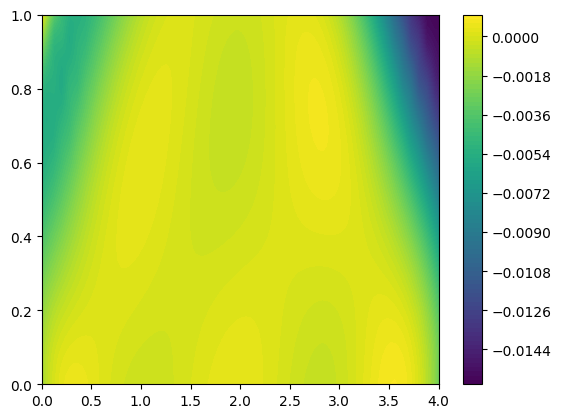

In [ ]:
x = np.linspace(0, L, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.reshape(10000,1),T.reshape(10000,1)))
Z = model.predict(XT)
plt.contourf(X, T, Z.reshape(100, 100)-u_solution.T, levels=100)
plt.colorbar()
plt.show()


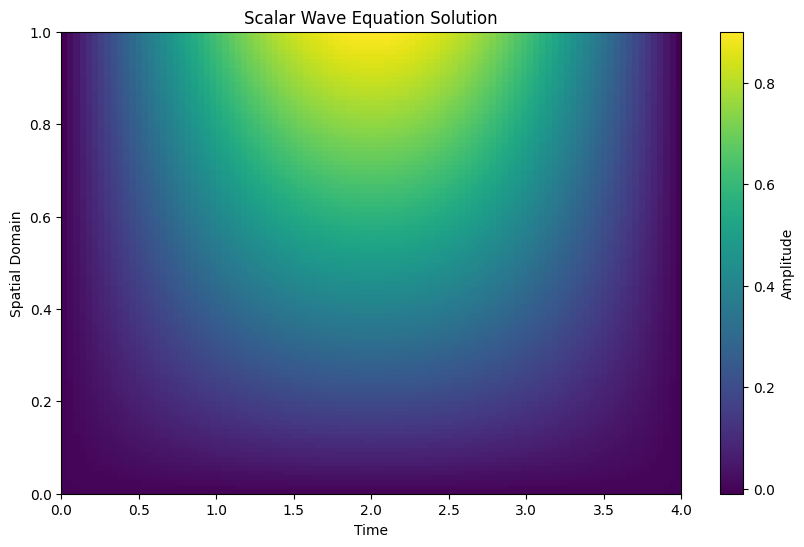

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
c = 1.0  # Wave speed
L = 4.0  # Length of spatial domain
T = 1.0   # Total simulation time
Nx = 100  # Number of spatial points
Nt = 100  # Number of time steps

# Discretize spatial domain
x_values = np.linspace(0, L, Nx)
dx = x_values[1] - x_values[0]

# Initial conditions
phi = np.sin(np.pi * x_values / L)  # Example initial condition
u0 = np.zeros_like(x_values)
u_t0 = phi

# Define the wave equation ODE system
def wave_equation(t, Y):
    u, u_t = np.split(Y, 2)
    u_xx = np.gradient(np.gradient(u, dx), dx)
    u_tt = c * u_xx
    return np.concatenate([u_t, u_tt])

# Combine initial conditions
Y0 = np.concatenate([u0, u_t0])

# Solve the system using solve_ivp
solution = solve_ivp(wave_equation, [0, T], Y0, t_eval=np.linspace(0, T, Nt), method='RK45', dense_output=True)

# Extract the solution
u_solution = solution.y[:Nx, :]
time_values = solution.t

# Plot the solution
plt.figure(figsize=(10, 6))
plt.imshow(u_solution.T, extent=[0, L, 0, T], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('Scalar Wave Equation Solution')
plt.xlabel('Time')
plt.ylabel('Spatial Domain')
plt.show()


### Question

Try changing initial conditions for the wave equation above. Does PINN`s solution get better or worse?

<a id="5"></a>
## Poisson equation

In $2$-dimensional cartesian coordinates, the **Poisson equation** takes the form
$$
\frac{\partial^2 u }{\partial x^2} +\frac{\partial^2 u }{\partial y^2} = f(x,y),\tag{10}
$$
where $f$ is a real (or complex) valued function, called the **source**.  

Let's solve this equation in the square $[0,1]\times [0,1]$.  We will impose the following boundary conditions
\begin{gather}
u(x, 0)  = x \qquad , \qquad
u(x, 1)  = x - 1, \\
u(0, y)  = -y\qquad ,\qquad
u(1, y)  = 1 - y.
\end{gather}

We calculate the Laplacian using finite difference approximations
$$
\Delta u \approx \frac{u(x+\Delta x,y)-2u(x,y)+u(x-\Delta x , y)}{\Delta x^2}+\frac{u(x,y+\Delta y)-2u(x,y)+u(x, y-\Delta y)}{\Delta y^2}. \tag{11}
$$

The approximate equation $\Delta u \approx f$ is then equivalent to  (assuming $\Delta x = \Delta y$)
$$
u(x,y)  \approx \frac{1}{4}\left( u(x+\Delta x,y)+u(x-\Delta x , y)+u(x,y+\Delta y)+u(x, y-\Delta y)-\Delta x^2 f(x,y) \right).\tag{12}
$$
We implement this in Python.

Converged after 1637 iterations.


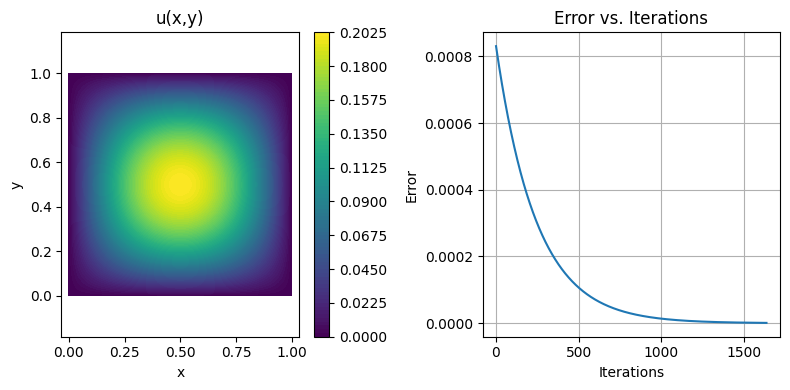

In [ ]:
# Define the grid parameters
n_x = 50  # Number of grid points in the x-direction
n_y = 50  # Number of grid points in the y-direction
x_min, x_max = 0.0, 1.0  # Domain boundaries in x
y_min, y_max = 0.0, 1.0  # Domain boundaries in y

# Create the grid
x = np.linspace(x_min, x_max, n_x)
y = np.linspace(y_min, y_max, n_y)
X, Y = np.meshgrid(x, y)

# the grid spacing
dx = (x_max - x_min) / (n_x - 1)
dy = (y_max - y_min) / (n_y - 1)

# Initialize the solution
u = np.zeros((n_y, n_x))
# the boundary conditions
# u[0, :] = x
# u[-1, :] = 1 - y
# u[:, 0] = -y
# u[:, -1] = x - 1

# The source term. You can change it to anything you want
def source_term(x, y):
    return -4*np.sin(np.pi*x)*np.sin(np.pi*y)

max_iterations = 10000
tolerance = 1e-6
error_list = []
iteration_list = []
# the optimization algorithm
for iteration in range(max_iterations):
    u_old = np.copy(u)
    for i in range(1, n_y - 1):
        for j in range(1, n_x - 1):
            u[i, j] = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1])
            u[i, j] += 0.25 * (u[i, j - 1] - dx**2 * source_term(x[j], y[i]))
    if np.max(np.abs(u - u_old)) < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break
    error = np.max(np.abs(u - u_old))
    error_list.append(error)
    iteration_list.append(iteration + 1)

# Plot the solution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, u, cmap='viridis', levels=100)
plt.colorbar()
plt.title('u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Plot the error as a function of iterations
plt.subplot(1, 2, 2)
plt.plot(iteration_list, error_list)
plt.title('Error vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.049575 s

'compile' took 0.415972 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.44e+00, 2.93e-02]    [3.44e+00, 2.93e-02]    []  
1000      [6.13e-04, 2.19e-03]    [6.13e-04, 2.19e-03]    []  
2000      [2.58e-04, 6.32e-04]    [2.58e-04, 6.32e-04]    []  
3000      [1.36e-04, 1.16e-04]    [1.36e-04, 1.16e-04]    []  
4000      [8.52e-05, 1.27e-05]    [8.52e-05, 1.27e-05]    []  
5000      [5.67e-05, 3.78e-06]    [5.67e-05, 3.78e-06]    []  
6000      [4.11e-05, 2.82e-06]    [4.11e-05, 2.82e-06]    []  
7000      [3.49e-05, 2.39e-06]    [3.49e-05, 2.39e-06]    []  
8000      [3.12e-05, 2.14e-06]    [3.12e-05, 2.14e-06]    []  
9000      [2.83e-05, 1.98e-06]    [2.83e-05, 1.98e-06]    []  
10000     [2.74e-05, 1.95e-06]    [2.74e-05, 1.95e-06]    []  
11000     [3.28e-05, 2.19e-06]    [3.28e-05, 2.19e-06]    []  
12000     [2.05e-05, 1.65e-06]    [2.05e-05,

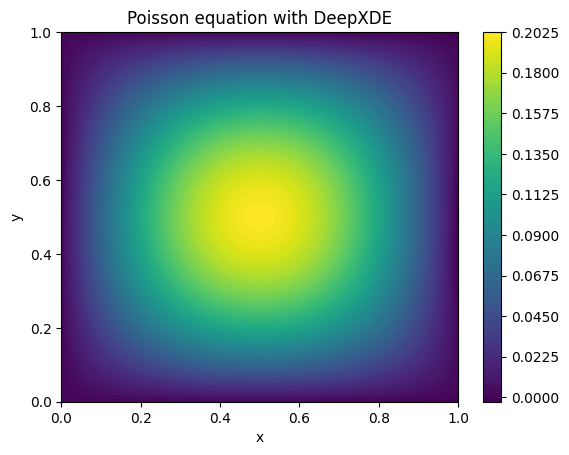

In [ ]:
def phi(x):
    return -4*tf.sin(np.pi*x[:,0:1])*tf.sin(np.pi*x[:,1:2])

def pde(x, y):
    h1 = dde.grad.hessian(y, x, i=0, j=0)
    h2 = dde.grad.hessian(y, x, i=0, j=0)
    return h1 + h2 - phi(x)

# define a grid
geom = dde.geometry.Rectangle((0,0), (1,1))

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)
def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)
def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0)
def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1)
def boundary(_, on_initial):
  return on_initial

bc_left = dde.icbc.DirichletBC(geom, lambda x: - x[:,1:2], boundary_left)
bc_right = dde.icbc.DirichletBC(geom, lambda x: 1 - x[:,1:2], boundary_right)
bc_bottom = dde.icbc.DirichletBC(geom, lambda x: x[:,0:1], boundary_bottom)
bc_top = dde.icbc.DirichletBC(geom, lambda x: x[:,0:1] - 1, boundary_top)

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

bcs = [bc_left, bc_right, bc_bottom, bc_top]

data = dde.data.PDE(
    geom, pde, bcs=bc, num_domain=1000, num_boundary=80,
)

net = dde.nn.FNN([2] + [30] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=15000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
X = X.reshape(10000,1)
Y = Y.reshape(10000,1)
Z = model.predict(np.hstack((X,Y)))
plt.tricontourf(X.flatten(), Y.flatten(), Z.flatten(), levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Poisson equation with DeepXDE")
plt.show()

### Question

You may play with different learning rates and number of iterations to see their influence, by modifying this part in the code above:
```python
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=15000)
```

<a id="6"></a>
## Eikonal equation

The **Eikonal equation** in geometric optics is a differential equation of the form
$$
\left|\nabla u(x)\right| = \frac{1}{c(x)},\tag{13}$$
for $x\in \mathbb{R}^n$, and $c$, a positive function, called the **speed function**. We take $n=2$ in this example, and we suppose that the speed is constant $c=1$. We integrate the equation over the square of side $L$.

Compiling model...
Building feed-forward neural network...
'build' took 0.072402 s

'compile' took 0.420586 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.09e-01, 6.57e-02]    [9.10e-01, 6.57e-02]    []  
1000      [2.88e-02, 1.18e-02]    [3.10e-02, 1.18e-02]    []  
2000      [5.94e-03, 7.76e-03]    [8.41e-03, 7.76e-03]    []  
3000      [3.34e-03, 5.98e-03]    [7.28e-03, 5.98e-03]    []  
4000      [2.87e-03, 5.37e-03]    [7.03e-03, 5.37e-03]    []  
5000      [2.50e-03, 4.07e-03]    [7.65e-03, 4.07e-03]    []  
6000      [2.22e-03, 3.59e-03]    [7.03e-03, 3.59e-03]    []  
7000      [1.85e-03, 2.94e-03]    [7.11e-03, 2.94e-03]    []  
8000      [1.69e-03, 1.76e-03]    [8.48e-03, 1.76e-03]    []  
9000      [1.30e-03, 1.03e-03]    [9.86e-03, 1.03e-03]    []  
10000     [1.11e-03, 8.55e-04]    [9.60e-03, 8.55e-04]    []  
11000     [9.34e-04, 7.48e-04]    [9.08e-03, 7.48e-04]    []  
12000     [7.18e-04, 6.01e-04]    [8.64e-03,

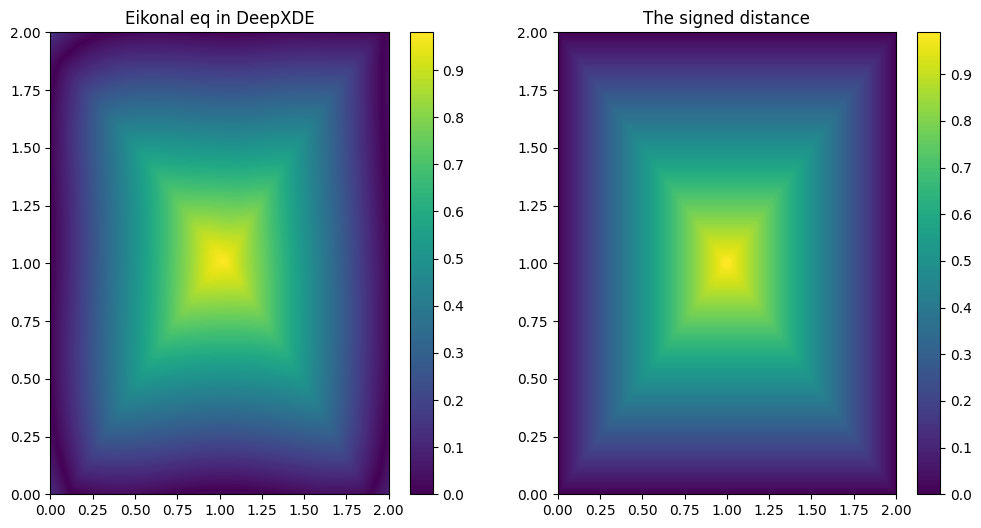

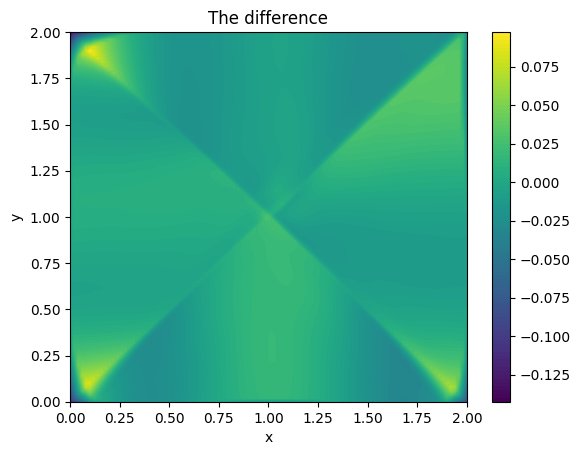

In [ ]:
# the side of the square
L = 2

def Eikonal_deepxde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_y = dde.grad.jacobian(y, x, i=0, j=1)
    return dy_x**2 + dy_y**2 - 1

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [L, L])

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    Eikonal_deepxde,
    bc,
    num_domain=400,
    num_boundary=32,
    num_test=400,
)

net = dde.nn.FNN(
    [2] + [20] * 4 + [1], 'tanh', "Glorot uniform"
)

# net.apply_output_transform(transform)

model = dde.Model(data, net)

model.compile("adam", lr=0.0005)

losshistory, train_state = model.train(iterations=20000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
X, Y = np.meshgrid(x,y)
Z_pred = model.predict(np.hstack((X.reshape(10000,1), Y.reshape(10000,1))))
Z_pred = abs(Z_pred)

# the target function is the signed distance function
def sdf(x,y):
  u = np.hstack((x, y, L-x, L-y))
  return np.min(u, axis=1)
Z_true = sdf(X.reshape(10000,1), Y.reshape(10000,1)).reshape(100,100)

#the plots
fig, axs = plt.subplots(1, 2,figsize=(12, 6))
plt.colorbar(axs[0].contourf(X, Y, Z_pred.reshape(100,100), levels=100))
plt.colorbar(axs[1].contourf(X, Y, Z_true, levels=100))
axs[0].set_title("Eikonal eq in DeepXDE")
axs[1].set_title("The signed distance")
plt.show()

# the difference
plt.contourf(X, Y, Z_true - Z_pred.reshape(100,100), levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("The difference")
plt.show()

The mean squared error is `mse = sum((Z_true.reshape(10000,1) - Z_pred)**2)/len(Z_pred) = 0.00024`.
The `l2 relative error` is `sum((Z_true.reshape(10000,1) - Z_pred)**2)/sum(Z_true.reshape(10000,1)**2) = 0.004`

### Question

Above, we solved the eikonal equation with boundary conditions on each side of the rectangle (0 at the boundaries). Try setting boundary conditions only on the left and top sides and solve the eikonal. Note, the true solution will also change. For hints see below.

Find these lines of code above:
```python
def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [L, L])

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)
```
Define new `boundary` function for the left and the top sides separately and then create boundary condition (BC) for them via `dde.icbc.DirichletBC`. You will have `bc_left` and `bc_top`. You might want to see examples in [Poisson equation](#5).

<a id="7"></a>
## Burgers' equation

We consider $1$-dimensional **Burgers' equation**
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \qquad x\in [-1,1],\; t\in [0,1] \tag{14}
$$
with the Dirichlet boundary conditions and initial conditions
$$
u(-1,t)=u(1,t)=0\quad \text{and}\quad u(x,0)=-\sin(\pi x).
$$

In [ ]:
# Define the viscosity (nu)
nu = 0.01

With SciPy

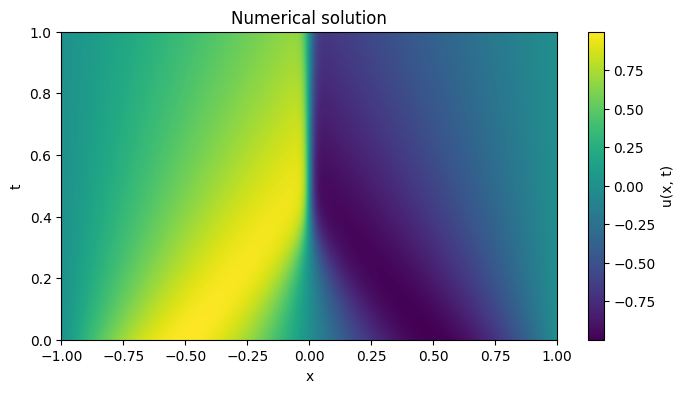

In [ ]:
# Define the spatial domain
L = 2.0
nx = 1000
dx = L / nx

# Define the time domain
T = 1.0
nt = 400
dt = T / nt

# Define the initial condition function
def initial_condition(x):
    return -np.sin(np.pi * x)

# Create arrays for the spatial and temporal grids
x = np.linspace(-1, 1, nx)  # Adjust the spatial domain to match the boundary conditions
u0 = initial_condition(x)

# Define the Burgers' equation with the boundary conditions
def burgers_equation(u, t):
    dudt = np.zeros_like(u)
    dudt[1:-1] = -u[1:-1] * (u[2:] - u[:-2]) / (2 * dx) + nu * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    dudt[0] = 0  # Boundary condition u(-1, t) = 0
    dudt[-1] = 0  # Boundary condition u(1, t) = 0
    return dudt

# Use SciPy's odeint to solve the equation over time
u_solution = odeint(burgers_equation, u0, np.linspace(0, T, nt))

# Visualize the results
plt.figure(figsize=(8, 4))
plt.imshow(u_solution, extent=[-1, 1, 0, T], origin='lower', aspect='auto')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Numerical solution')
plt.show()

With DeepDXE

In [ ]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - nu * dy_xx

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.093046 s

'compile' took 0.929377 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.07e-01, 2.36e-01, 9.15e-01]    [3.07e-01, 2.36e-01, 9.15e-01]    []  
1000      [3.74e-02, 1.22e-03, 4.66e-02]    [3.74e-02, 1.22e-03, 4.66e-02]    []  
2000      [9.53e-03, 6.82e-05, 1.65e-02]    [9.53e-03, 6.82e-05, 1.65e-02]    []  
3000      [4.09e-03, 1.50e-05, 3.46e-03]    [4.09e-03, 1.50e-05, 3.46e-03]    []  
4000      [1.85e-03, 4.66e-06, 1.17e-03]    [1.85e-03, 4.66e-06, 1.17e-03]    []  
5000      [1.14e-03, 4.84e-06, 4.54e-04]    [1.14e-03, 4.84e-06, 4.54e-04]    []  
6000      [7.57e-04, 2.41e-06, 2.52e-04]    [7.57e-04, 2.41e-06, 2.52e-04]    []  
7000      [5.46e-04, 1.36e-06, 1.71e-04]    [5.46e-04, 1.36e-06, 1.71e-04]    []  
8000      [4.24e-04, 6.39e-07, 1.21e-04]    [4.24e-04, 6.39e-07, 1.21e-04]    []  
9000      [3.89e-04, 1.32e-06, 9.

Let's visualize the results.

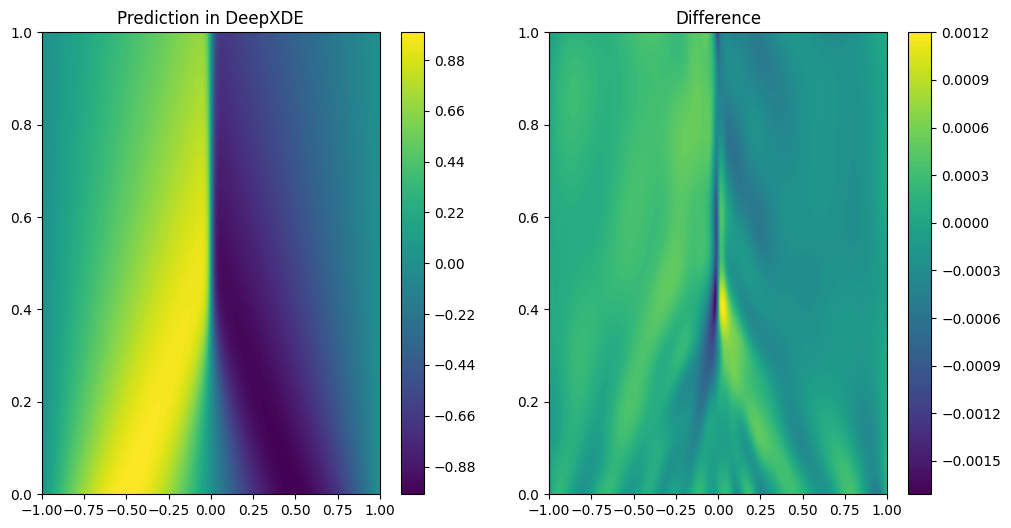

In [ ]:
x = np.linspace(-1,1,1000)
t = np.linspace(0,1,400)
X, T = np.meshgrid(x, t)
X_flat = X.reshape(400000,1)
T_flat = T.reshape(400000,1)
Y_pred = model.predict(np.hstack((X_flat,T_flat)))

#the plots
fig, axs = plt.subplots(1, 2,figsize=(12, 6))
plt.colorbar(axs[0].contourf(X, T, Y_pred.reshape(400,1000), levels=100))
plt.colorbar(axs[1].contourf(X, T, Y_pred.reshape(400,1000) - u_solution, levels=100))
axs[0].set_title("Prediction in DeepXDE")
axs[1].set_title("Difference with the numerical sol")
plt.show()

The mean squared error is `mse = sum((Y_pred-u_solution.reshape(400000,1))**2)/len(Y_pred) = 8e-8`. The `l2 relative error` is `sum((Y_pred-u_solution.reshape(400000,1))**2)/sum((u_solution.reshape(400000,1))**2)
 = 2.22e-7`.

<a id="8"></a>
## Camassa-Holm eqution

Consider **Camassa-Holm** equation $$
u_t - u_{xxt} + 3uu_{x} -2 u_xu_{xx} - uu_{xxx} = 0,
$$
with initial condition
$$
u(x,0)= ce^{-|x|},
$$
where $c$ is a constant.

In [ ]:
c = 2
def pde(X, u):
    x, t = X[:,0:1], X[:,1:2]
    u_t = dde.grad.jacobian(u, X, i=0, j=1)
    u_x = dde.grad.jacobian(u, X, i=0, j=0)
    u_xx = dde.grad.hessian(u, X, i=0, j=0)
    u_xxx = dde.grad.jacobian(u_xx, X, i=0, j=0)
    u_xxt = dde.grad.jacobian(u_xx, X, i=0, j=1)
    return u_t - u_xxt + 3*u*u_x - 2*u_x*u_xx - u*u_xxx

geom = dde.geometry.Interval(-2, 2)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def u0(x):
    return c*tf.exp(-tf.abs(x))

ic = dde.icbc.IC(
    geomtime, lambda x: u0(x[:,0:1]), lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime, pde, [ic], num_domain=64, num_boundary=64, num_initial=160
)

net = dde.nn.FNN([2] + [24] * 6 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=30000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.158353 s

'compile' took 3.194556 s

Training model...

0         [9.37e-02, 9.84e-01]                                            [9.37e-02, 9.84e-01]                                            []  
1000      [9.20e-03, 3.11e-02]                                            [9.20e-03, 3.11e-02]                                            []  
2000      [2.25e-03, 6.43e-03]                                            [2.25e-03, 6.43e-03]                                            []  
3000      [1.21e-03, 3.58e-03]                                            [1.21e-03, 3.58e-03]                                            []  
4000      [1.19e-03, 2.79e-03]                                            [1.19e-03, 2.79e-03]                                            []  
5000      [7.83e-04, 2.34e-03]                                            [7.83e-04, 2.34e-03]                                            []  
6000      [6

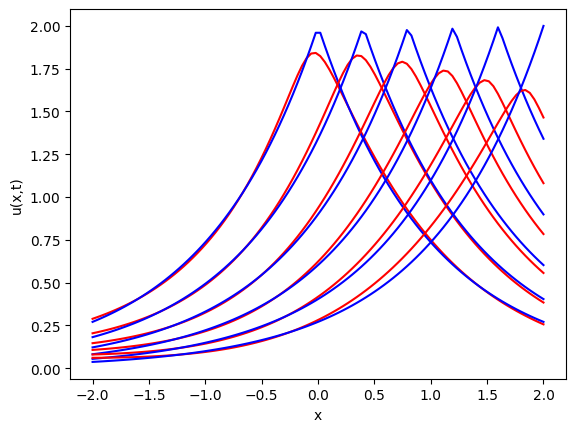

In [ ]:
x = np.linspace(-2,2,100).reshape(100,1)
for k in range(6):
    t = np.array([k*0.2]*100).reshape(100,1)
    X = np.hstack((x,t))
    plt.plot(x.flatten(),model.predict(X).flatten(), color="red", label="prediction")
    plt.plot(x.flatten(), c*np.exp(-np.abs(c*t.flatten()-x.flatten())), color="blue", label="true value")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
plt.show()

The plot compares the true function $x\mapsto u(x,t)$, in blue, to the predicted values, in red, at $t=0,0.2, 0.4, 0.6, 0.8$ and $t=1$. Notice how as time passes by, the predicted values become less accurate. Also, the prediction near the singularity of the target function isn't accurate. The singularity in this case is the line given by the equation $ct-x=0$.